# Qualitative analysis and topic modelling on TED Talks using NLP
## Introduction:-
In this project, I have tried to do topic modelling on a dataset containing TED Talks ([kaggle](https://www.kaggle.com/datasets/jeniagerasimov/ted-talks-info-dataset?rvi=1)) using LDA (Latent Dirichlet Allocation). I have also tried to judge the quality of each topic using the number of likes and views talks on each topic have
## Tech used:-
I have used the following python libraries:-
1. Pandas for data handling
2. Spacy for tokenisation and lematisation of text
3. Gensim for the LDA model
4. matplotlib for plotting data
5. Wordcloud for topic visualisation
## Prerequisites and installaions:-
The machine should have python with pip PATH included.
If you are following along in a Jupyter notebook, exectute the following cell to install required packages
Alternatively, you can type out each of the pip installation commands giiven below on the terminal manually.

In [ ]:
! pip install pandas
! pip install spacy
! python -m spacy download en_core_web_sm
! pip install gensim
! pip install matplotlib
! pip install pyLDAvis
! pip install wordcloud

We can get started by importing the required modules into our code.

In [ ]:
import pandas as pd
import spacy
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Let's load the dataset from a csv file to a pandas dataframe

In [2]:
talks = pd.read_csv("./data/talks_info.csv", header=0)

Cleaning text is really important for data analysis. In the following function, I convert the likes column of the dataframe from string like '17K' and '2M' to a uniform float type.
I also remove the rows that have NULL instances.

In [4]:
def refine_likes(likes):
    if 'str' in str(type(likes)):
        if likes[-1] == 'K':
            return float(likes[:-1])*1000
        elif likes[-1] == 'M':
            return float(likes[:-1])*1000000
        else:
            return float(likes)
    else:
        return float(likes)
talks = talks.dropna(axis=0, how="any")
talks['likes'] = talks['likes'].apply(refine_likes)

The next step is cleaning the text in the **Transcript** column. LDA uses a bag-of-words approach for modelling. So, giving the model a tokenised, lemmatised list of relevant tokens and removin irrelevant word.
I chose spacy for this step as it's model is efficient in POS-tagging (Part Of Speech tagging), through which I can remove tokens that serve as adverbs, pronouns, coordinating conjunctions, punctuations, participles, determiners, adpositions, spaces, numbers and symbols.

Spacy is also good at lemmatisation. So, I create a list of relevant lemmatised tokens and append it to the dataframe as a column.

*If you are following along on your machine, this step might take a while (took around 30 minutes on my machine). I have saved the resulting dataframe to a csv file named **talks.csv**. I will be loading that in the next step, so feel free to skip this step.*

In [ ]:
nlp = spacy.load('en_core_web_sm')
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for plot in nlp.pipe(talks['transcript']):
   proj_tok = [token.lemma_.lower() for token in plot if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)
talks["tokens"] = tokens
talks.to_csv("./data/talks.csv")

Loading the dataframe from the csv file with the resulting dataframe of previous step

In [3]:
talks = pd.read_csv("./data/talks.csv")
talks["tokens"] = talks["tokens"].apply(lambda tokens: eval(tokens))

The dictionary class from gensim is used to tag each word to a unique number.

We can then filter out words that occur too few or too many times through all the transcripts.

Finally, we create a corpus containing sparse vectors of tokens in each talk.

In [3]:
dictionary = Dictionary(talks['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [dictionary.doc2bow(doc) for doc in talks['tokens']]

An important desicion to take when it comes to using LDA models is to evaluate what is the ideal number of topics. 
While this is normally done by trial and error, it can also be done by calculating the coherence score of the model using the *CoherenceModel* from gensim

*Coherence score is calculated by evaluating the semantic similarity of the tokens present in each model. A higher coheence score usually means a better model.*

The LDA model is generated through the LdaMulticore class offered by gensim. It is designed to make the best use of multicore processors. Set the **workers** field in the code to the number of cores in your machine to get the best performance.

*This step may take upto 30 minutes*

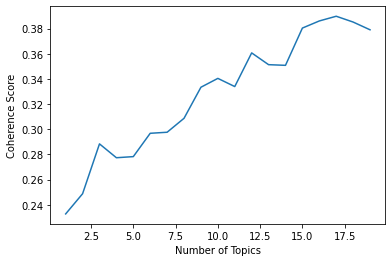

In [8]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = talks['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

We see that the coherence score peaks at 17. 

When we generate the LDA model with 17 topics, we get the following results.

We can use WordCloud to visualise the weights of words in each topic

[('black', 0.023199594), ('design', 0.012679465), ('police', 0.010360298), ('white', 0.0100761745), ('group', 0.009874321), ('social', 0.009781051), ('community', 0.009514624), ('law', 0.008618214), ('justice', 0.00854274), ('question', 0.007928073)]


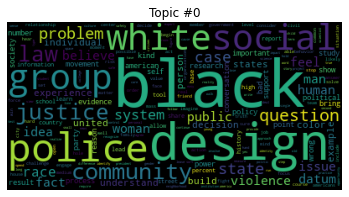

[('city', 0.030607175), ('water', 0.024869263), ('space', 0.014834348), ('earth', 0.014807622), ('building', 0.01370674), ('build', 0.011908808), ('planet', 0.011552969), ('design', 0.008313019), ('map', 0.007223119), ('tree', 0.0067081773)]


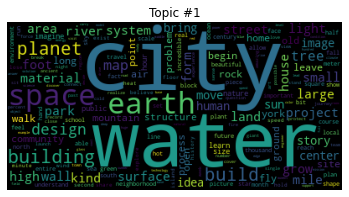

[('feel', 0.015441467), ('baby', 0.012323784), ('number', 0.011726577), ('answer', 0.008024135), ('bad', 0.007935642), ('arm', 0.0072233966), ('point', 0.006650009), ('pain', 0.00641064), ('minute', 0.0063614454), ('leave', 0.0061798864)]


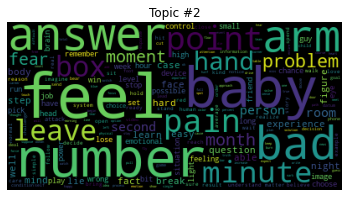

[('school', 0.019695647), ('student', 0.01707953), ('percent', 0.012044323), ('education', 0.01133453), ('sleep', 0.01114241), ('kid', 0.011011076), ('money', 0.010984017), ('child', 0.010349109), ('teacher', 0.008714952), ('high', 0.008567895)]


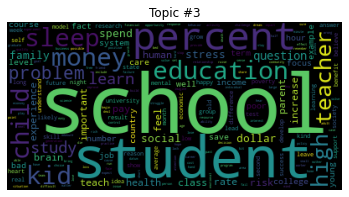

[('energy', 0.025464512), ('climate', 0.020636566), ('carbon', 0.01293071), ('car', 0.012102732), ('power', 0.011061925), ('percent', 0.009661897), ('fuel', 0.009149974), ('solar', 0.008648966), ('gas', 0.008312455), ('plant', 0.008247573)]


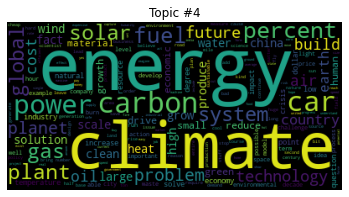

[('animal', 0.029739726), ('male', 0.015901927), ('specie', 0.015230366), ('human', 0.013946253), ('female', 0.013215324), ('bird', 0.011748561), ('body', 0.010355651), ('plant', 0.008579517), ('africa', 0.007647792), ('tree', 0.006305593)]


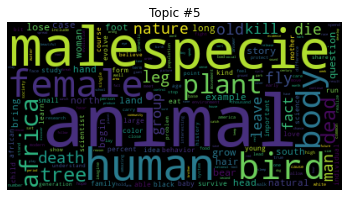

[('story', 0.01960335), ('war', 0.016470006), ('country', 0.013690683), ('book', 0.0098486), ('history', 0.009737687), ('political', 0.0077877804), ('century', 0.007742478), ('power', 0.007510843), ('society', 0.0065525677), ('art', 0.0059225806)]


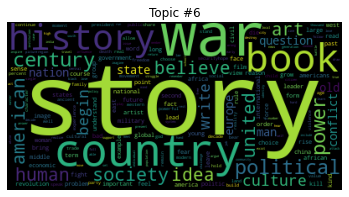

[('woman', 0.030477023), ('man', 0.018695524), ('feel', 0.01235169), ('love', 0.012107668), ('girl', 0.01091943), ('story', 0.009969305), ('family', 0.0098535605), ('child', 0.009451963), ('old', 0.00790487), ('mother', 0.0075517427)]


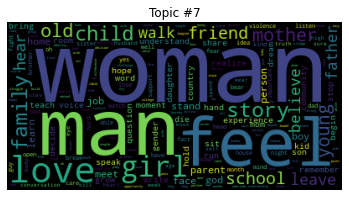

[('music', 0.03024506), ('play', 0.017973023), ('feel', 0.016713968), ('sound', 0.014803404), ('love', 0.013573438), ('hear', 0.009340373), ('idea', 0.008584924), ('song', 0.007949045), ('experience', 0.006428728), ('moment', 0.0062251803)]


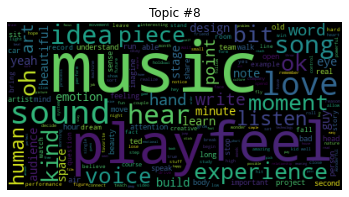

[('ocean', 0.02823049), ('food', 0.026574844), ('fish', 0.023926023), ('eat', 0.016602267), ('sea', 0.015221848), ('water', 0.014069161), ('number', 0.012453016), ('animal', 0.009759974), ('percent', 0.0092606675), ('specie', 0.008805801)]


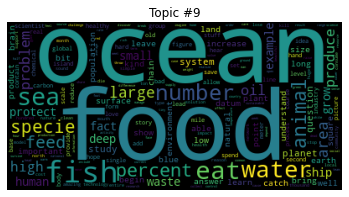

[('patient', 0.031201763), ('health', 0.028016182), ('care', 0.021594917), ('doctor', 0.021121016), ('cancer', 0.017877297), ('medical', 0.015708141), ('hospital', 0.014150818), ('treatment', 0.010315285), ('heart', 0.0095607005), ('disease', 0.0094808)]


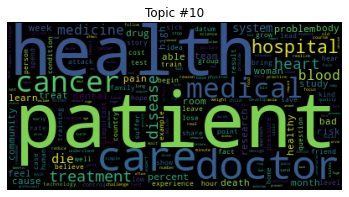

[('company', 0.019050995), ('business', 0.011127429), ('technology', 0.010861268), ('datum', 0.01057871), ('build', 0.009681172), ('idea', 0.009282772), ('system', 0.008889366), ('government', 0.008493933), ('problem', 0.008213065), ('information', 0.007899175)]


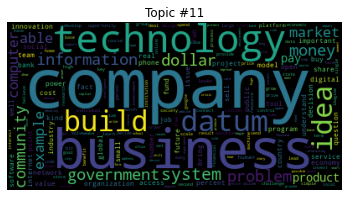

[('country', 0.028892728), ('health', 0.014438435), ('africa', 0.013371145), ('food', 0.012097341), ('percent', 0.011407019), ('child', 0.011055621), ('system', 0.009327807), ('disease', 0.008291529), ('community', 0.008163564), ('population', 0.0070193326)]


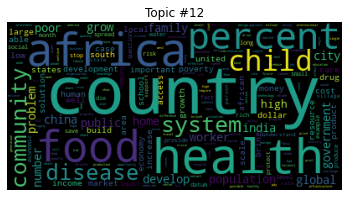

[('idea', 0.011277528), ('video', 0.010088371), ('game', 0.009527817), ('kind', 0.009086055), ('science', 0.008487737), ('bit', 0.007205797), ('computer', 0.007064837), ('real', 0.0066517554), ('question', 0.0064187194), ('fact', 0.0063195103)]


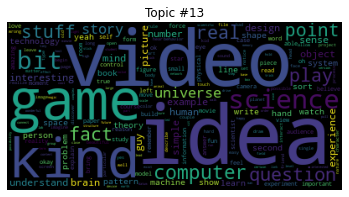

[('language', 0.02935981), ('word', 0.022933094), ('medium', 0.011912199), ('speak', 0.010778549), ('english', 0.009532705), ('country', 0.008492816), ('trust', 0.007835766), ('question', 0.007200715), ('internet', 0.00719891), ('write', 0.006935584)]


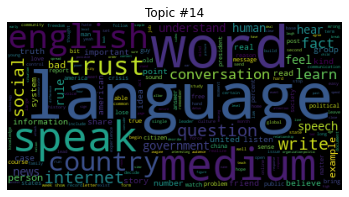

[('child', 0.0232858), ('kid', 0.022567548), ('human', 0.017502008), ('learn', 0.010691411), ('old', 0.009823256), ('dog', 0.009419861), ('computer', 0.0076402626), ('technology', 0.007574767), ('school', 0.007517686), ('feel', 0.0067283143)]


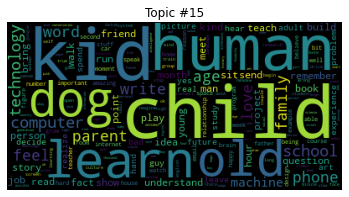

[('cell', 0.029316604), ('brain', 0.029192654), ('light', 0.014998572), ('body', 0.014787449), ('human', 0.0110778), ('disease', 0.008462412), ('drug', 0.008154585), ('system', 0.007831351), ('able', 0.006785658), ('technology', 0.006407728)]


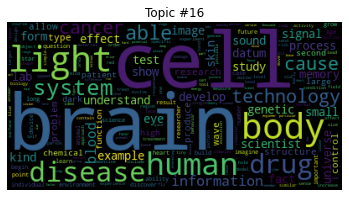

In [10]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=17, workers = 8, passes=10)
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    print(lda_model.show_topic(t, 10))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

We can now assign the most likely topic of each talk by going through summary of each talk and passing it through our model.

These are the labels I manually assigned to each of the resulting topics :-

*These topics vary from run to run, you might get a completely different set of topics on your run*
  
- Topic 0 - race, justice

![topic 0](./images/topic0.png)
- Topic 1 - city planning, resources

![topic 1](./images/topic1.png)
- Topic 2 - ideation, motivation

![topic 2](./images/topic2.png)
- Topic 3 - education

![topic 3](./images/topic3.png)
- Topic 4 - climate change, resorces

![topic 4](./images/topic4.png)
- Topic 5 - nature, animals

![topic 5](./images/topic5.png)
- Topic 6 - stories, wars, politics

![topic 6](./images/topic6.png)
- Topic 7 - feelings, family

![topic 7](./images/topic7.png)
- Topic 8 - music

![topic 8](./images/topic8.png)
- Topic 9 - sea, nature, food

![topic 9](./images/topic9.png)
- Topic 10 - health, diseases

![topic 10](./images/topic10.png)
- Topic 11 - business, companies

![topic 11](./images/topic11.png)
- Topic 12 - geo-politics, nutrition

![topic 12](./images/topic12.png)
- Topic 13 - creativity, multi-media

![topic 13](./images/topic13.png)
- Topic 14 - language

![topic 14](./images/topic14.png)
- Topic 15 - humans, pets, aging

![topic 15](./images/topic15.png)
- Topic 16 - brain, neuro-science

![topic 16](./images/topic16.png)

Now we can visualise each topic through the **pyLDAvis** module.

*We can save the resulting visualisation as a html page and open it through a browser. I have saved it as **index.html***

In [12]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_display, 'index.html')
pyLDAvis.display(lda_display)

c:\Users\Sai Madhavan G\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [13]:
talks['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(talks['summary']))]

## Observations:-

For evaluating the quality of TED Talks, we will take a look at 3 parameters
- Number of likes
- Number of views
- Number of likes by number of views

So let's calculate the number of likes by number of views for each topic

In [14]:
talks['likes_by_views'] = talks['likes']/talks['views']

Now, let's look at the average number of likes talks on each topic has

topic
0      67677.497717
1      61989.683043
2     104791.989394
3      82452.541667
4      56559.621083
5      59301.395349
6      64676.767857
7      61948.087432
8      70444.822695
9      58006.250000
10     59688.172043
11     68025.714286
12     43250.000000
13     55400.000000
14    105750.000000
15     66500.000000
16     99687.500000
Name: likes, dtype: float64


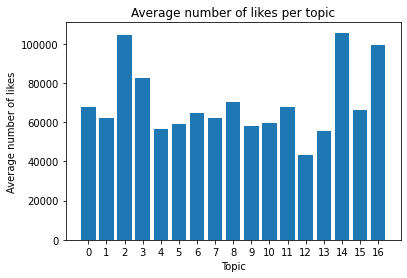

In [20]:
labels = list(range(lda_model.num_topics))
like_values = list(talks.groupby(by=['topic']).mean()['likes'])
print(talks.groupby(by=['topic']).mean()['likes'])
plt.bar(labels, like_values)
plt.title("Average number of likes per topic")
plt.xlabel("Topic")
plt.xticks(list(range(lda_model.num_topics)))
plt.ylabel("Average number of likes")
plt.show()

We see that topic 14 (language) is the most liked topic closely followed by topic 2 (motivation)

Let's now look at how each topic performs on views

topic
0     2.280018e+06
1     2.083636e+06
2     3.517072e+06
3     2.772348e+06
4     1.900823e+06
5     1.994372e+06
6     2.171277e+06
7     2.081127e+06
8     2.368392e+06
9     1.947262e+06
10    2.020091e+06
11    2.284580e+06
12    1.451983e+06
13    1.861802e+06
14    3.541066e+06
15    2.248077e+06
16    3.341489e+06
Name: views, dtype: float64


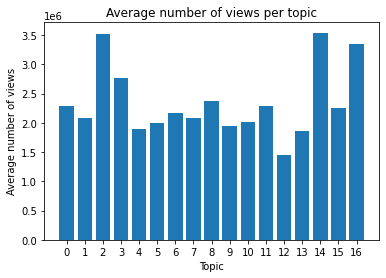

In [22]:
labels = list(range(lda_model.num_topics))
like_values = list(talks.groupby(by=['topic']).mean()['views'])
print(talks.groupby(by=['topic']).mean()['views'])
plt.bar(labels, like_values)
plt.title("Average number of views per topic")
plt.xlabel("Topic")
plt.xticks(list(range(lda_model.num_topics)))
plt.ylabel("Average number of views")
plt.show()

We see a very close resemblance to the number of likes each topic got

It's now time to compare the number of likes by number of views of each topic

topic
0     0.029605
1     0.029575
2     0.029662
3     0.029662
4     0.029633
5     0.029565
6     0.029597
7     0.029629
8     0.029616
9     0.029655
10    0.029586
11    0.029560
12    0.029727
13    0.029685
14    0.029736
15    0.029565
16    0.029564
Name: likes_by_views, dtype: float64


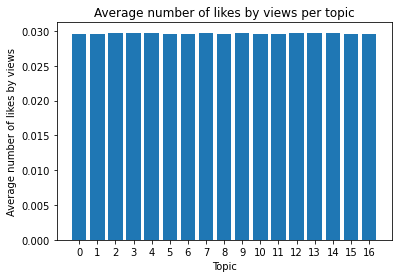

In [23]:
labels = list(range(lda_model.num_topics))
like_values = list(talks.groupby(by=['topic']).mean()['likes_by_views'])
print(talks.groupby(by=['topic']).mean()['likes_by_views'])
plt.bar(labels, like_values)
plt.title("Average number of likes by views per topic")
plt.xlabel("Topic")
plt.xticks(list(range(lda_model.num_topics)))
plt.ylabel("Average number of likes by views")
plt.show()

We observe that this ratio remains almost contant throughout all the topics.

## Conclusions:-

### Conclusions regarding the data:-

1. Talks concerning language, motivation and neuro-science, seem to perform the best in terms of likes and views
2. Talks concerning nutrition, multi-media and climate change, seem to perform the worst in terms of likes and views
3. The number of likes a talk gets seems to be a consitent fraction of the number of views. This is perhaps, more representative of audience than the quality of a talk

### Conclusions regarding the LDA algorithm:-

I shall list down the pros and cons of using LDA algorithm for toic modelling based on my my experience with it

**Pros**:-
1. It is efficient and quick
2. It can be specific and correct a majority of the times

**Cons**:-
1. It can be vague and topics can be too general at times
2. It has a certain degree of randomness that makes keeping things uniform difficult
3. Since it uses a bag-of-words approach, a lot of meaning gets lost

**My overall conclusion**:-

LDA is a super-efficient algorithm that can be really useful in specific use-cases with significant margins of error.